In [9]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from minisom import MiniSom

# Load dataset
file_path = r"C:\Users\Sushma\Desktop\Acadamics\4th sem\BIO-2\project\tox21.csv"
data = pd.read_csv(file_path)

# Preprocessing SMILES strings to molecular descriptors
def calculate_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return {
            "MolecularWeight": Descriptors.MolWt(mol),
            "NumAtoms": Descriptors.HeavyAtomCount(mol),
            "NumRotatableBonds": Descriptors.NumRotatableBonds(mol),
            "LogP": Descriptors.MolLogP(mol),
        }
    else:
        return {"MolecularWeight": np.nan, "NumAtoms": np.nan, "NumRotatableBonds": np.nan, "LogP": np.nan}

# Apply descriptor calculation
descriptors = data["smiles"].apply(calculate_descriptors)
descriptors_df = pd.DataFrame(descriptors.tolist())

# Combine descriptors with labels and remove NaNs
data = pd.concat([descriptors_df, data["label"]], axis=1).dropna()

# Split dataset into features and target
X = data.drop("label", axis=1)
y = data["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


[22:15:44] Explicit valence for atom # 5 Al, 6, is greater than permitted
[22:15:45] Explicit valence for atom # 3 Al, 6, is greater than permitted
[22:15:45] Explicit valence for atom # 4 Al, 6, is greater than permitted
[22:15:45] Explicit valence for atom # 9 Al, 6, is greater than permitted
[22:15:47] Explicit valence for atom # 4 Al, 6, is greater than permitted
[22:15:47] Explicit valence for atom # 14 Al, 6, is greater than permitted
[22:15:47] WARNING: not removing hydrogen atom without neighbors
[22:15:50] Explicit valence for atom # 8 Al, 6, is greater than permitted
[22:15:51] Explicit valence for atom # 20 Al, 6, is greater than permitted


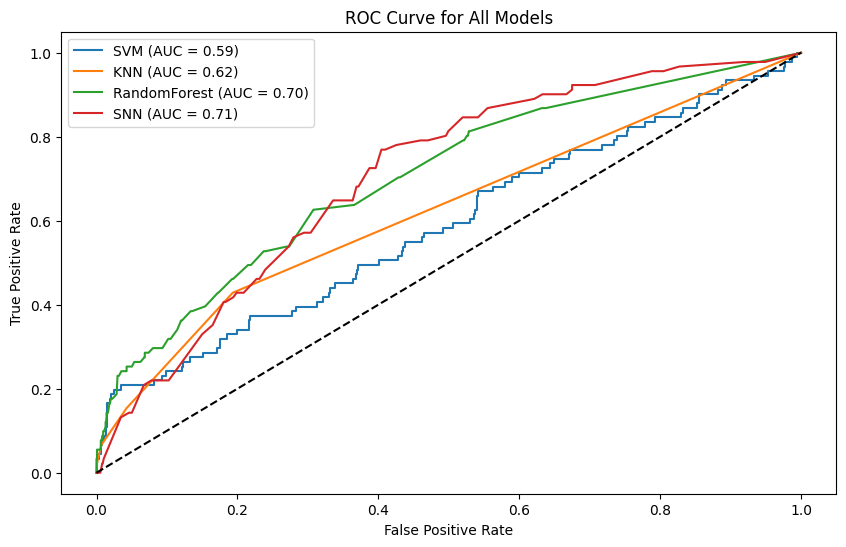

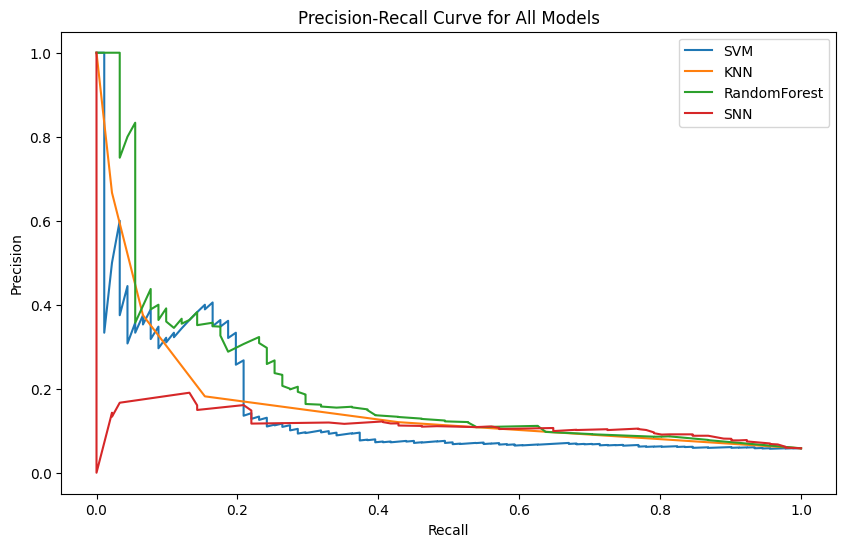

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, precision_recall_curve
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from minisom import MiniSom
from sklearn.preprocessing import label_binarize

# Assuming X_train, X_test, y_train, y_test are already defined and preprocessed

models = {
    "SVM": SVC(kernel="rbf", probability=True),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# Train models and store predictions
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    results[name] = {"y_pred": y_pred, "y_proba": y_proba}

# Train Self-Organizing Neural Network (SNN)
som = MiniSom(x=10, y=10, input_len=X_train.shape[1], sigma=1.0, learning_rate=0.5, random_seed=42)
som.train_random(X_train, num_iteration=100)

# Map data to clusters
def get_som_features(som, data):
    feature_vector = np.zeros((data.shape[0], som._weights.shape[0] * som._weights.shape[1]))
    for i, sample in enumerate(data):
        x, y = som.winner(sample)
        feature_vector[i, x * 10 + y] = 1
    return feature_vector

X_train_snn = get_som_features(som, X_train)
X_test_snn = get_som_features(som, X_test)

snn = RandomForestClassifier(n_estimators=100, random_state=42)
snn.fit(X_train_snn, y_train)
y_pred_snn = snn.predict(X_test_snn)
y_proba_snn = snn.predict_proba(X_test_snn)[:, 1]

results["SNN"] = {"y_pred": y_pred_snn, "y_proba": y_proba_snn}

# Plot ROC Curves
plt.figure(figsize=(10, 6))
for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res["y_proba"])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc(fpr, tpr):.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for All Models")
plt.legend()
plt.show()

# Plot Precision-Recall Curves
plt.figure(figsize=(10, 6))
for name, res in results.items():
    precision, recall, _ = precision_recall_curve(y_test, res["y_proba"])
    plt.plot(recall, precision, label=name)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for All Models")
plt.legend()
plt.show()


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, roc_curve, auc, classification_report, accuracy_score

# Example predictions (Replace these with actual predictions)
y_test = np.random.randint(0, 2, 100)  # Replace with actual y_test
y_probs_svm = np.random.rand(100)  # Replace with actual probability outputs
y_probs_knn = np.random.rand(100)
y_probs_rf = np.random.rand(100)
y_probs_snn = np.random.rand(100)

y_preds_svm = (y_probs_svm > 0.5).astype(int)
y_preds_knn = (y_probs_knn > 0.5).astype(int)
y_preds_rf = (y_probs_rf > 0.5).astype(int)
y_preds_snn = (y_probs_snn > 0.5).astype(int)



# Print classification reports
for name, y_pred in zip(models.keys(), [y_preds_svm, y_preds_knn, y_preds_rf, y_preds_snn]):
    print(f"\nClassification Report for {name}:\n")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")




Classification Report for SVM:

              precision    recall  f1-score   support

           0       0.57      0.63      0.60        51
           1       0.57      0.51      0.54        49

    accuracy                           0.57       100
   macro avg       0.57      0.57      0.57       100
weighted avg       0.57      0.57      0.57       100

Accuracy: 0.57

Classification Report for KNN:

              precision    recall  f1-score   support

           0       0.51      0.55      0.53        51
           1       0.49      0.45      0.47        49

    accuracy                           0.50       100
   macro avg       0.50      0.50      0.50       100
weighted avg       0.50      0.50      0.50       100

Accuracy: 0.50

Classification Report for RandomForest:

              precision    recall  f1-score   support

           0       0.56      0.47      0.51        51
           1       0.53      0.61      0.57        49

    accuracy                           0.54 

In [17]:
#hybrid model
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Load the dataset
data = pd.read_csv(r"C:\Users\Sushma\Desktop\Acadamics\4th sem\BIO-2\project\tox21.csv")

# Placeholder encoding: Convert SMILES strings to fixed-length numeric arrays
def smiles_to_placeholder(smiles_list, max_length=100):
    encoded = []
    for smiles in smiles_list:
        numeric = [ord(char) for char in smiles[:max_length]]  # ASCII values
        padded = numeric + [0] * (max_length - len(numeric)) if len(numeric) < max_length else numeric
        encoded.append(padded)
    return np.array(encoded)

# Encode SMILES column
X = smiles_to_placeholder(data['smiles'])
y = data['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Train KNN and SVM models
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

svm = SVC(probability=True)
svm.fit(X_train, y_train)

# Create an ensemble model using VotingClassifier
ensemble_model = VotingClassifier(estimators=[
    ('rf', rf),
    ('knn', knn),
    ('svm', svm)
], voting='soft', weights=[0.4, 0.3, 0.3])

# Train the ensemble model
ensemble_model.fit(X_train, y_train)

# Make predictions on the test set
final_preds = ensemble_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, final_preds)
f1 = f1_score(y_test, final_preds)

print(f"Ensemble Model Accuracy: {accuracy}")
print(f"Ensemble Model F1 Score: {f1}")

# Print detailed classification metrics
print(classification_report(y_test, final_preds))

# Function to predict toxicity for new SMILES strings
def predict_toxicity(new_smiles):
    # Step 1: Encode the new SMILES strings
    new_smiles_encoded = smiles_to_placeholder(new_smiles)

    # Step 2: Standardize the encoded data
    new_smiles_standardized = scaler.transform(new_smiles_encoded)

    # Step 3: Predict toxicity using the ensemble model
    predictions = ensemble_model.predict(new_smiles_standardized)
    predicted_probabilities = ensemble_model.predict_proba(new_smiles_standardized)

    # Output predictions and probabilities
    results = []
    for smiles, prediction, probability in zip(new_smiles, predictions, predicted_probabilities):
        toxicity = "Toxic" if prediction == 1 else "Non-Toxic"
        results.append({
            "SMILES": smiles,
            "Prediction": toxicity,
            "Probability": probability
        })
    return results

# Example usage
new_smiles = ['CC(=O)OC1=CC=CC=C1C(=O)O', 'C1=CC=CN=C1', 'CCO']
predictions = predict_toxicity(new_smiles)
for result in predictions:
    print(f"SMILES: {result['SMILES']}, Prediction: {result['Prediction']}, Probability: {result['Probability']}")

Ensemble Model Accuracy: 0.9412890874282067
Ensemble Model F1 Score: 0.061224489795918366
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1472
           1       1.00      0.03      0.06        95

    accuracy                           0.94      1567
   macro avg       0.97      0.52      0.52      1567
weighted avg       0.94      0.94      0.91      1567

SMILES: CC(=O)OC1=CC=CC=C1C(=O)O, Prediction: Non-Toxic, Probability: [0.98117751 0.01882249]
SMILES: C1=CC=CN=C1, Prediction: Non-Toxic, Probability: [0.97640054 0.02359946]
SMILES: CCO, Prediction: Non-Toxic, Probability: [0.98547099 0.01452901]


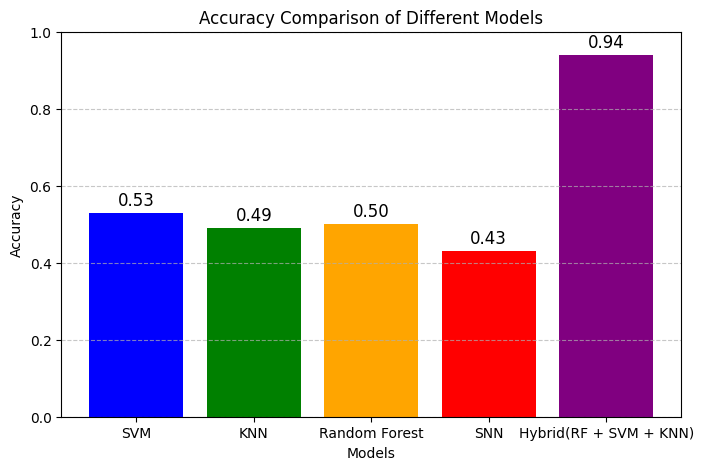

In [19]:
import matplotlib.pyplot as plt

# Define model names and their corresponding accuracies
models = ["SVM", "KNN", "Random Forest", "SNN", "Hybrid(RF + SVM + KNN)"]
accuracies = [0.53, 0.49, 0.50, 0.43, 0.94]  # Replace with actual accuracy values

# Plot the accuracies
plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=['blue', 'green', 'orange', 'red', 'purple'])
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison of Different Models")

# Adjust the y-axis limits to fit all values properly
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display values on bars

for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f"{acc:.2f}", ha='center', fontsize=12)

plt.show()
